# Introduction to Programming: Group TC_1 Project

Done by:

``
Farouq El-Abbass (49412)
Simone Michelle Binder (53382)
Elias Gehrke (54796)
Francesco Melchiori (55279)
``


## Project description

**Our project consists of forecasting energy consumption for specific countries, using data from ``Our World In Data``. The data set in question is a csv-file from GitHub. It originated from Our World In Data comprising multiple data sources and containing energy data on energy consumption (primary energy, per capita, and growth rates), energy mix, electricity mix and other relevant metrics.** 

In our group project we started coding with an “object-oriented approach” that, in simple terms, is a programming pattern that is built around objects or entities. Object-oriented programming (OOP) organizes software design around data, or objects, rather than functions and logic. An object could be defined as a data field that has special attributes and behavior. OOP has a focus on the objects that we want to manipulate rather than the logic that is adopted to manipulate them. This approach to programming is perfect for programs that are big, complex and needs to be updated regularly. OOP offers a lot of flexibility and power. The usage of objects rather than common data types can simplify a lot a programming task and boost the re-usability rate of the program. Flexibility of the codes is provided for your codebase through polymorphism and inheritance. There are other benefits of OOP that include code scalability, efficiency and reusability. 

Thanks to the advantage of the OOP, we tried to analyze the energy consumption of the following countries: "Morocco", "Mexico", "Germany", "China", "India", "United States", taking into account specific factors: “country", "year", "gdp", "renewables_energy_per_capita", "fossil_energy_per_ capita". After gathering data on these categories, we then compared the countries to observe the differences and the divergent gaps, based on the categories we selected. All the codes are flexible thanks to the OOP approach and this gives the advantage for us to adapt fast and quickly all the codes simply by changing the countries and or the categories we want to analyze. Theis gives us the opportunity to continuously revise and update correctly the work if something is missing or is incorrect.  

In order to start our project and to avoid having the whole notebook fully occupied we decided to put our codes in a different file called Energy. Inside this class we imported all the libraries we needed to start and go on with our work: 

-	Request: It is a famous open-source HTTP library that makes it easier to work with HTTP requests. It removes the complexities of making requests using a simple API so that you can instead focus on interacting with services and consuming data in your application. 
-	Pandas: It is an adaptable and powerful quantitative analysis tool used for data analysis which is now one of the most popular libraries in Python. It is also built on top of another package named Numpy, which is useful for multi-dimensional arrays.
-	Matplotlib: is a library used to create 2D graphs and is able to produce plots using python scripts. Plotting is easier thanks to the module called pyplot that provides features to control line styles, fonts, formatting columns etc.
-	Pmdarima: is a statistical library used for different purpose that includes: (i) Cross-validation utilities, (ii) collection of statistical tests of seasonality and stationarity, (iii) time series utilities (e.g. differencing and inverse differencing) etc. 


We decided to separate the code from the notebook, if you'd wish to load it, please use the magic function below.

In [1]:
# %load "energy.py"

### **Loading the OO code and constructing the object**

In [2]:
from energy import Energy

In [3]:
analysis = Energy()

### **Printing the data**

In [4]:
analysis.print_data()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,Afghanistan,1900,AFG,4832414.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1901,AFG,4879685.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1902,AFG,4935122.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1903,AFG,4998861.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1904,AFG,5063419.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Cleaning the data and selecting relevant variable**

Now we call our method ``clean_data()`` to remove the missing values, and select only the 3 relevant variables to our project which are ``gdp``, ``renewables_energy_per_capita``, ``fossil_energy_per_capita``, in addition to the country name and year.

In [5]:
analysis.clean_data()
analysis.print_data()

,country,year,gdp,renewables_energy_per_capita,fossil_energy_per_capita
70,Afghanistan,1970,1.581223e+10,0.0,0.0
71,Afghanistan,1971,1.577051e+10,0.0,0.0
72,Afghanistan,1972,1.317055e+10,0.0,0.0
73,Afghanistan,1973,1.356863e+10,0.0,0.0
74,Afghanistan,1974,1.430911e+10,0.0,0.0


### **Visualization of GDP, Fossil and renewable energies consumptions per country**

Here we are filtering the data by samples of developed and developing countries.

In [6]:
developed_countries = ["United States", "China", "Germany"]
df_dev = analysis.filter_countries(developed_countries)


under_countries = ["Morocco","Mexico","India"]
df_under = analysis.filter_countries(under_countries)

#### **GDP plots**

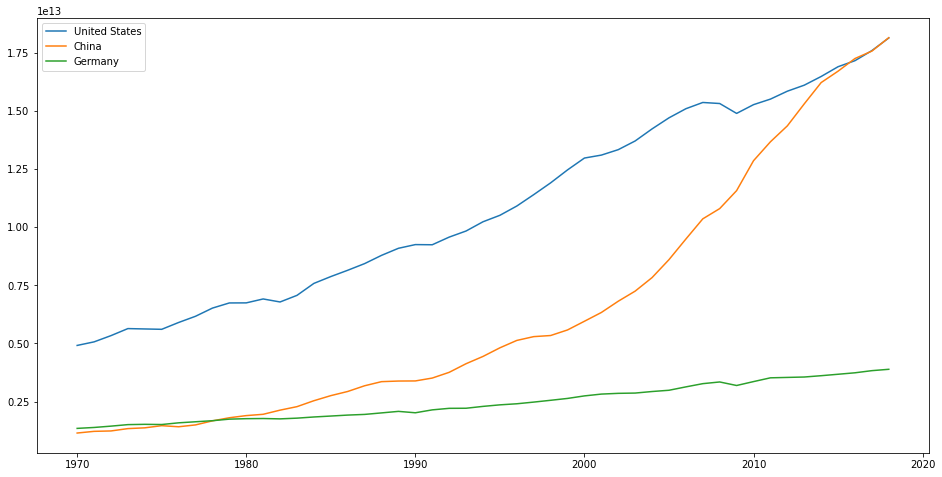

In [7]:
analysis.plots(df_dev ,"gdp", countries=developed_countries)

Starting from 1970, the US was takking the lead on the GDP, but in the long run China's GDP have increased exponentially to close the gap with the US.

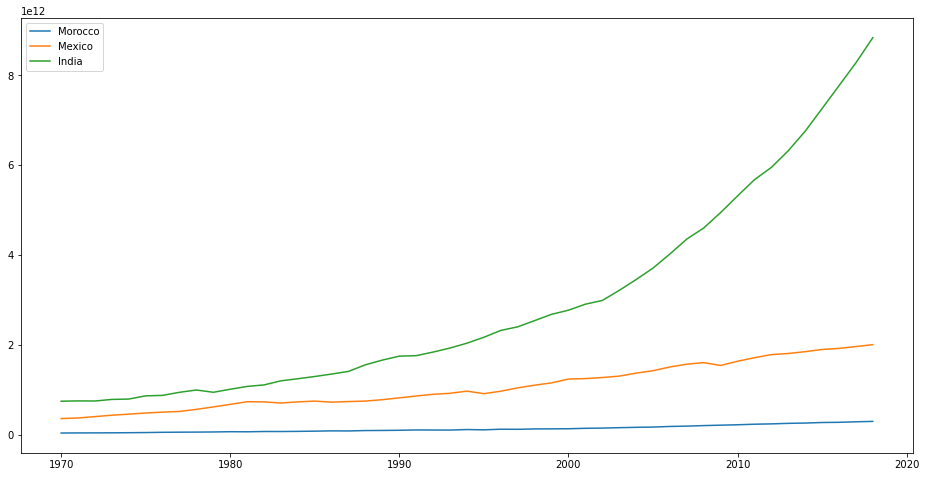

In [8]:
analysis.plots(df_under ,"gdp", countries=under_countries)

Here we see that India's GDP has an exponential curve whereas Mexico and Morocco are monotonous.

#### **Fossil energies plots**

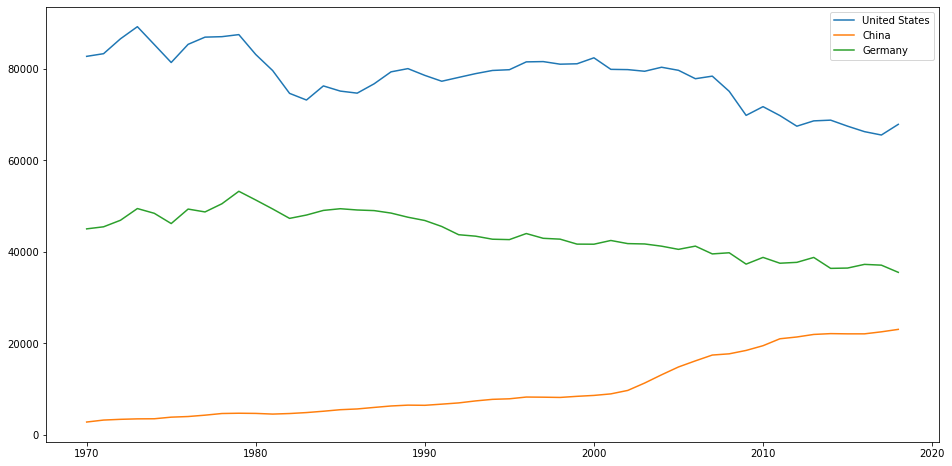

In [9]:
analysis.plots(df_dev ,"fossil", countries=developed_countries)

The US and Germany have a decrease in fossil energy consumption whereas China is increasing their fossil consumption after 2000.

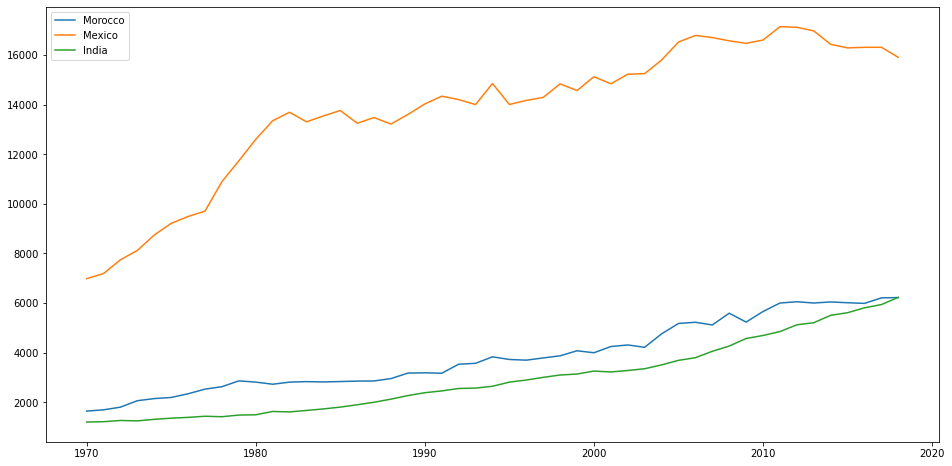

In [10]:
analysis.plots(df_under ,"fossil", countries=under_countries)

All the developing countries are raising their consumption in fossil energy, namely Mexico that takes the lead in fossil consumption in this graph.

#### **Renewables plots**

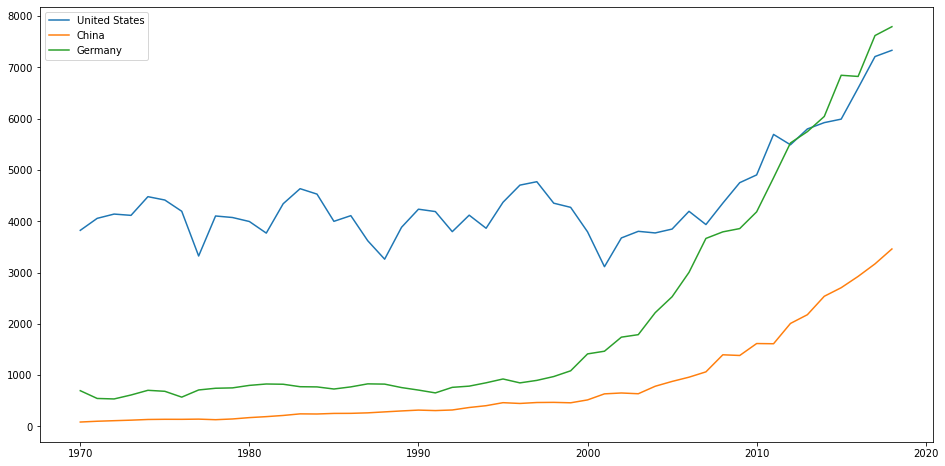

In [11]:
analysis.plots(df_dev ,"renewables", countries=developed_countries)

Before 2000, the renewables consumption had a monotonous curve. However, it be observable that after 2000, developed countries started to invest more on renewables, namely Germany that increased their renewables consumption the most and that exceeded the US after 2010. 

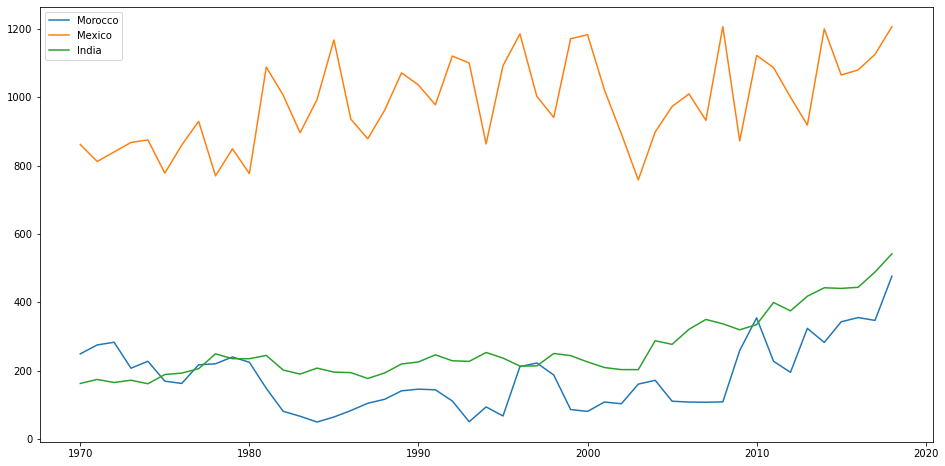

In [12]:
analysis.plots(df_under ,"renewables", countries=under_countries)

Developing countries don't take into account renewable energies as much as the developed ones, however we can se a slight increase for Morocco and India after 2010

### **Key Takeaways**

***The countries like the US and Germany are increasing their renewable energy consumption whereas in China not. For developing countries, India is taking the lead in terms of GDP growth, but they are still relying on fossil energy. We also can see that there is no clear direct pattern between growth of GDP and growth in either fossil or renewables energy consumption***

### **Forecast of GDP, renewables and fossil energy consumptions**

In the last part of the project, we will forecast a variable of our interest for a given list of countries. As we have time series data for GDP, renewables energy consumption per capita and fossil energy consumption per capita from 1970 to 2018, we decided to make a time series forecast for the next 10 years.

Therefore, we will choose an ``ARIMA (autoregressive integrated moving average) model``. This model allows us to combine an autoregressive model (AR), which describes deterministic time-series data based on its own lagged past values, with a moving-average model (MA), which involves modeling the error term as a combination of error terms occurring at various times in the past. The AR and MA models require stationary time series, meaning that the underlying distribution function of the time series values must be constant over time. Mean and variance are the same at all times and do not follow a trend, for example. The special feature of the ARIMA model is that it can filter out trends by means of additional differentiation and integration and establish the required stationarity through this trend removal. Therefore, the ARIMA model can be used to analyze and describe time series data that follow a trend. 

The arima_forecast function receives a list of the desired countries and the variable of interest. In the first step, for each country in our list, we check which of the three given types of variables the function receives. It can either be “fossil”, “renewables” or “gdp”. In the next step, for each type, the same procedure is applied. First, we use the auto_arima method to get the best values of the parameters used in the ARIMA model, i.e. ``p, q and d``. We save the best combination in our variable o and feed this combination to our ARIMA model to forecast the next 10 years. Lastly, we plot our past data for each country together with our time series prediction from the ARIMA model.


We will be using ``auto_arima()`` from ``pmdarima`` to do a grid search for the best parameters of ``ARIMA(p,d,q)``, and then feed it to ``ARIMA()`` for forecasting each variable for the two datasets. 

**It is going to give a total of 6 graphs: 3 variables plots for 2 datasets.**

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2638.563, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2633.966, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2648.120, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2636.481, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2685.936, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.265 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2571.031, Time=0.06 sec


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2571.721, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2573.355, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2572.563, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2568.800, Time=0.29 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2567.395, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=2568.874, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=2570.712, Time=0.39 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2569.305, Time=0.08 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 1.243 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2492.016, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2492.865, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2495.052, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2493.973, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.426 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


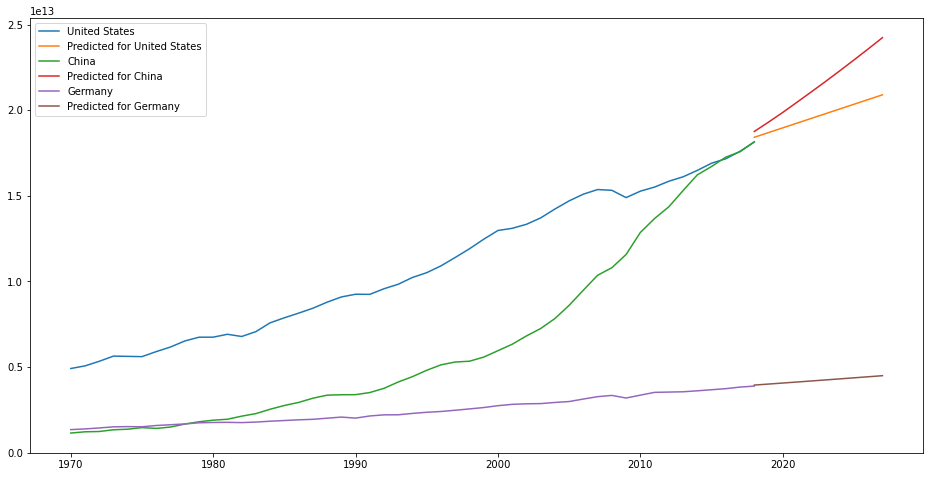

In [13]:
analysis.arima_forecast(df_dev ,countries=developed_countries, type="gdp")

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=881.974, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=878.055, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=879.656, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=880.142, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=877.027, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.551 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=698.082, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=733.302, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=696.153, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=712.593, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=758.641, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=698.048, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=698.436, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=697.113, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.936 seconds
Performing stepwise search to minimize aic


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=834.554, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=830.307, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=832.246, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=832.367, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=829.375, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.503 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


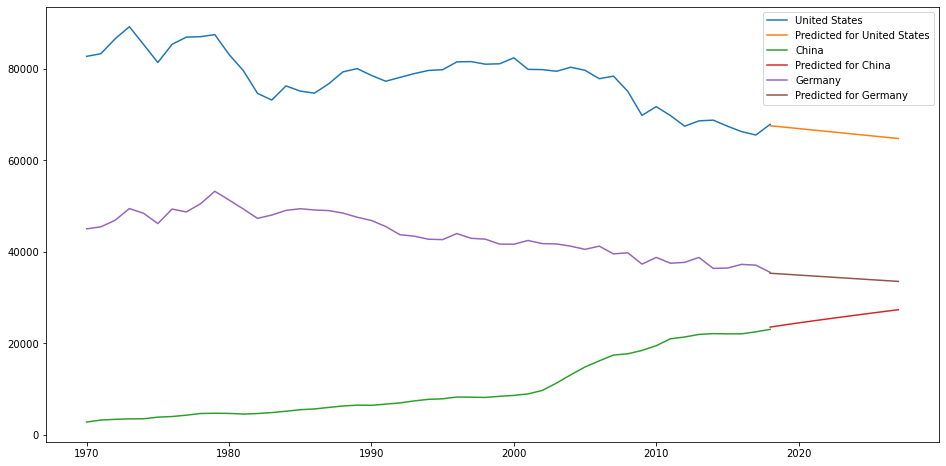

In [14]:
analysis.arima_forecast(df_dev ,countries=developed_countries, type="fossil") 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=714.980, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=710.999, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=712.984, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=712.981, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=710.727, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.760 seconds
Performing stepwise search to minimize aic


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


 ARIMA(1,2,1)(0,0,0)[0]             : AIC=537.194, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=582.753, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=538.332, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=549.693, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=538.290, Time=0.27 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=536.047, Time=0.27 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=539.332, Time=0.24 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=538.034, Time=0.34 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=537.979, Time=0.40 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=540.885, Time=0.46 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=inf, Time=0.74 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=534.427, Time=0.61 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=537.800, Time=0.42 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=535.818, Time=0.48 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=536.682, Time=0.92 sec
 ARIMA(1,2,3)(0,0,0)[0] inter

c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=631.158, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=660.713, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=640.469, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=632.469, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=633.075, Time=0.26 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=629.850, Time=0.16 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=627.531, Time=0.32 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=625.128, Time=0.49 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=inf, Time=0.88 sec
 ARIMA(0,2,5)(0,0,0)[0]             : AIC=624.403, Time=0.85 sec
 ARIMA(1,2,5)(0,0,0)[0]             : AIC=inf, Time=0.92 sec
 ARIMA(0,2,6)(0,0,0)[0]             : AIC=625.932, Time=0.73 sec
 ARIMA(1,2,6)(0,0,0)[0]             : AIC=inf, Time=0.84 sec
 A

c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(
c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


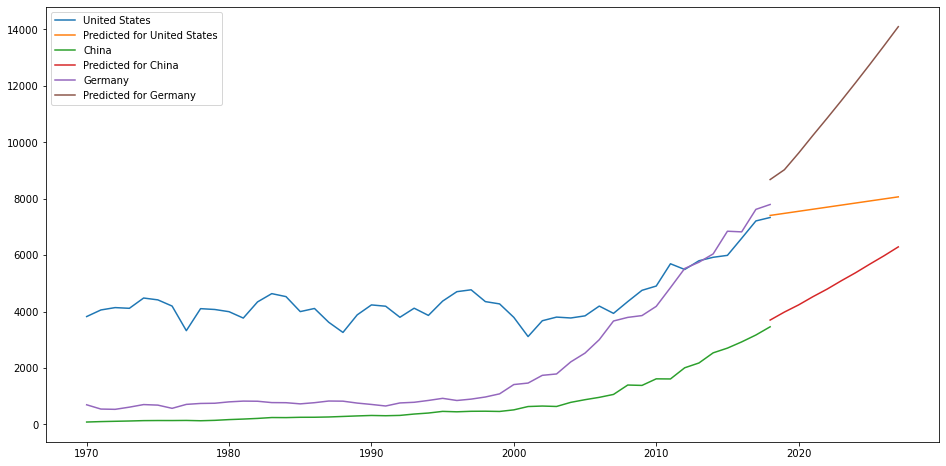

In [15]:
analysis.arima_forecast(df_dev ,countries=developed_countries, type="renewables")

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2251.624, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2267.397, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2256.476, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2238.490, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2241.632, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2250.023, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.018 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2466.043, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2461.991, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2464.493, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2464.084, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2496.839, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.264 seconds
Performing stepwise search to minimize aic


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2464.818, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2463.019, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2464.333, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2464.051, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2462.910, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2464.978, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2465.951, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2466.585, Time=0.13 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 0.537 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


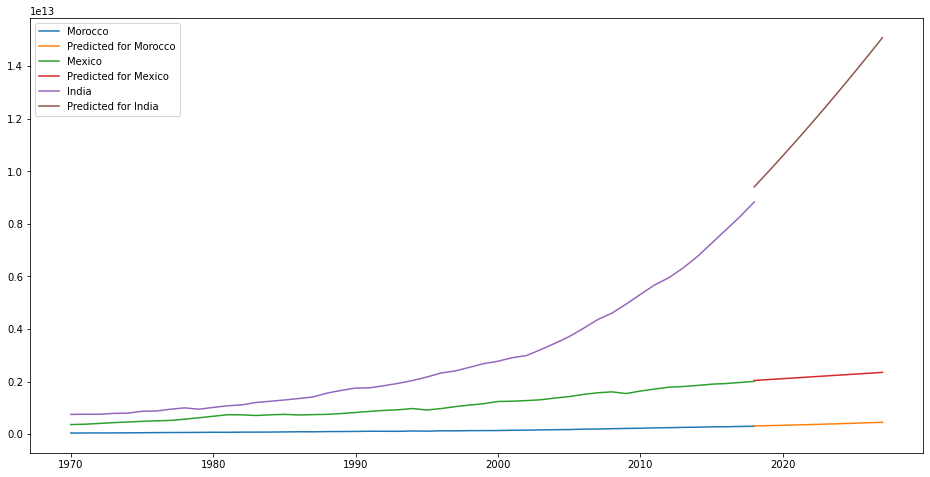

In [16]:
analysis.arima_forecast(df_under ,countries=under_countries, type="gdp")

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=634.210, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=633.547, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=632.782, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=632.237, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=644.604, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=634.190, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=635.998, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=646.471, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.006 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=706.326, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=727.472, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=710.851, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=704.381, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=706.340, Time=0.18 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=707.130, Time=0.26 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.885 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=528.729, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=560.429, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=528.913, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=533.923, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=529.999, Time=0.28 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=530.592, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=531.999, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=529.056, Time=0.07 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=531.893, Time=0.40 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=529.617, Time=0.18 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.457 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


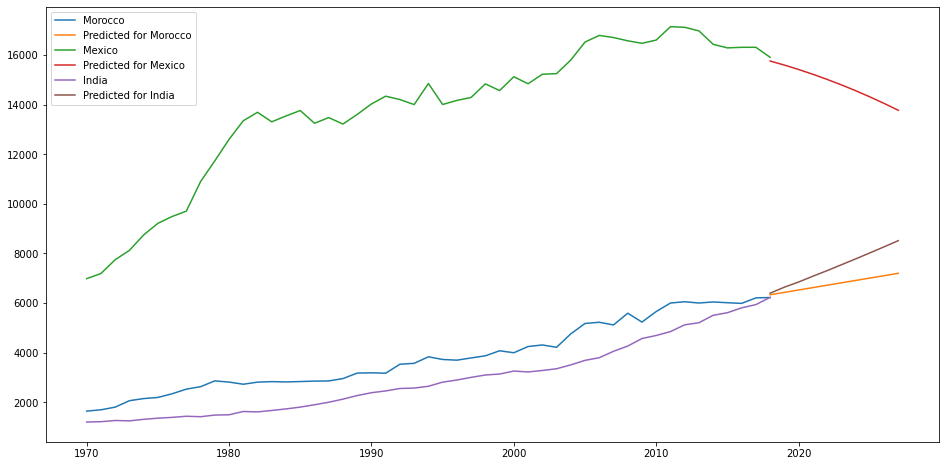

In [17]:
analysis.arima_forecast(df_under ,countries=under_countries, type="fossil")

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=543.978, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=590.433, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=542.203, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=559.673, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=662.540, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=544.058, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=544.400, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=544.401, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.462 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=617.039, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=611.605, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=596.895, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=615.159, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=597.582, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.863 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=454.976, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=451.174, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=453.052, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=453.030, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=453.579, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.438 seconds


c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: x. After release 0.14, this will raise.
  warnings.warn(


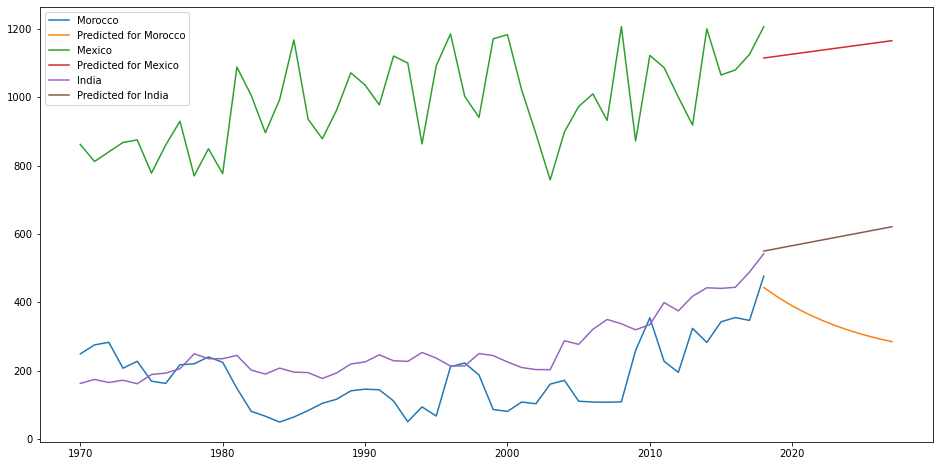

In [18]:
analysis.arima_forecast(df_under ,countries=under_countries, type="renewables")

***The forecast always follows the general trend per country, however it can't be very exact because we don't have that many observations per country. Looking at the graphs we summarized the future development of the selected countries: for the developed countries the GDP is expected to increase, the fossil energy is predicted to stay monotonous or either slightly decrease or increase, however the renewables consumption is expected to increase strongly.***
***For the developing countries, we cannot conclude on a developping pattern because each country behaves differently with respect to specific variables.***